In [1]:
# Django, Geopandas, etc related setup.

import os, sys
PROJECTPATH = os.environ['PWD']
sys.path.insert(0, PROJECTPATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mygeo.settings")
os.environ.setdefault("DJANGO_PROJECT", "mygeo")
os.environ.setdefault("LOCAL_DB", "1")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from mygeo import settings
os.chdir(PROJECTPATH)
import django
django.setup()
import json
import pprint
import geopandas
import shapely
import matplotlib
import matplotlib.colors as mcolors
from django.core.serializers import serialize
from shapely.geometry import MultiLineString
from shapely.ops import triangulate

from world.models import Parcel, ZoningBase, BuildingOutlines


logging.config.dictConfig


**** RUNNING IN (insecure) DEVELOPMENT MODE ****
****** LOCAL DATABASE ******


Lot:  0    1034.619544
dtype: float64
buildings:  0     41.803916
1    146.275525
dtype: float64


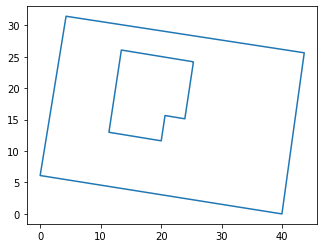

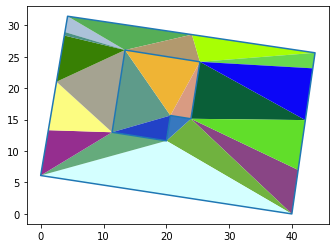

In [4]:
apn = '4302030800'

# Get parcel and building info for this zone.
parcel = Parcel.objects.get(apn=apn)
buildings = BuildingOutlines.objects.filter(geom__intersects=parcel.geom)

# convert building and parcel data into a UTM projection, which is a flat
# geometry where each unit is 1 meter.
serialized_parcel = serialize('geojson', [parcel], geometry_field='geom', )
serialized_buildings = serialize('geojson', buildings, geometry_field='geom', fields=('apn', 'geom',))
parcel_data_frame = geopandas.GeoDataFrame.from_features(json.loads(serialized_parcel), crs="EPSG:4326")
buildings_data_frame = geopandas.GeoDataFrame.from_features(json.loads(serialized_buildings), crs="EPSG:4326")
parcel_in_utm = parcel_data_frame.to_crs(parcel_data_frame.estimate_utm_crs())
buildings_in_utm = buildings_data_frame.to_crs(buildings_data_frame.estimate_utm_crs())

# do some basic sanity checks
lot_square_meters = parcel_in_utm.area
print ("Lot: ", lot_square_meters)
print ("buildings: ", buildings_in_utm.area)
assert (len(parcel_in_utm.boundary) == 1)
assert (len(buildings_in_utm.boundary) == 2)
assert (len(parcel_in_utm.boundary[0].geoms) == 1)
assert (len(buildings_in_utm.boundary[0].geoms) == 1)

# TODO: Algorithm currently only uses first building. extend it to multiple buildings

# move building coordinates to be 0,0 based so they're easier to see.
boundary_line_string = parcel_in_utm.boundary[0].geoms[0]
building_line_string = buildings_in_utm.boundary[1].geoms[0]
bounds = boundary_line_string.bounds
boundary_line_string = shapely.affinity.translate(boundary_line_string, xoff=-bounds[0], yoff=-bounds[1])
building_line_string = shapely.affinity.translate(building_line_string, xoff=-bounds[0], yoff=-bounds[1])

# do basic building and boundary plot
base = geopandas.GeoDataFrame(geometry=[building_line_string, boundary_line_string], crs="EPSG:4326")
base.plot()

# try plotting triangles
triangles = triangulate (MultiLineString([boundary_line_string, building_line_string]))

trigeo = geopandas.GeoDataFrame(geometry=[building_line_string, boundary_line_string], crs="EPSG:4326")
p = trigeo.plot()
colorkeys = list(mcolors.XKCD_COLORS.keys())
for i in range(len(triangles)):
    geopandas.GeoSeries(triangles[i]).plot(ax=p, color=colorkeys[i % len(colorkeys)])
    

In [ ]:
# Playing around with geometry commands

[x.intersection(boundary_line_string) for x in triangles]